# Exploratory Data Analysis

## What is remaining
- Feature engineering
- Plots
- Feature importance
- model comparison
- threshold tuning

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

### Load Data

In [3]:
# import data
df = pd.read_csv('../data/diabetic_data.csv')

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
df.shape

(101766, 50)

### Handle missing data

In [5]:
df = df.replace('?', np.nan)
df.isna().sum().sort_values(ascending=False)

weight                      98569
max_glu_serum               96420
A1Cresult                   84748
medical_specialty           49949
payer_code                  40256
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
patient_nbr                     0
time_in_hospital                0
admission_source_id             0
num_lab_procedures              0
encounter_id                    0
admission_type_id               0
discharge_disposition_id        0
gender                          0
age                             0
number_inpatient                0
number_emergency                0
number_outpatient               0
num_medications                 0
num_procedures                  0
number_diagnoses                0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [6]:
# Drop columns with 30 to 90% null values
df = df.drop(columns=[
    'weight',
    'max_glu_serum',
    'A1Cresult',
    'medical_specialty',
    'payer_code'
], axis=1)

# Handle missing values and format categorical values
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['number']).columns

for c in cat_cols:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df[cat_cols] = df[cat_cols].fillna('NA')
df[num_cols] = df[num_cols].fillna(0.0)

In [7]:
df.isna().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide

In [8]:
# Map age
age_map = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}
df['age'] = df['age'].map(age_map)

### Target Variable

In [9]:
# Define the target variable: readmitted
# 'NO' → not readmitted
# '>30' → readmitted after 30 days
# '<30' → readmitted within 30 days

df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x=='<30' else 0 )

### Feature Engineering

In [10]:
df = df.drop(columns=['encounter_id', 'patient_nbr'], errors='ignore')

In [11]:
df.nunique().sort_values(ascending=False)

diag_3                      790
diag_2                      749
diag_1                      717
num_lab_procedures          118
num_medications              75
number_outpatient            39
number_emergency             33
discharge_disposition_id     26
number_inpatient             21
admission_source_id          17
number_diagnoses             16
time_in_hospital             14
age                          10
admission_type_id             8
num_procedures                7
race                          6
glyburide-metformin           4
metformin                     4
repaglinide                   4
nateglinide                   4
chlorpropamide                4
glimepiride                   4
glipizide                     4
pioglitazone                  4
glyburide                     4
acarbose                      4
rosiglitazone                 4
miglitol                      4
insulin                       4
gender                        3
tolazamide                    3
tolbutam

In [12]:
def engineer_features(df):
    # Create additional predictive features while preserving the original columns.

    # -------- Visit history / intensity features --------
    df['total_previous_visits'] = (
        df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
    )

    df['had_previous_inpatient'] = (df['number_inpatient'] > 0).astype(int)

    # Avoid division by zero by adding +1 to the denominator
    df['avg_medications_per_day'] = df['num_medications'] / (df['time_in_hospital'] + 1)
    df['procedure_to_lab_ratio'] = df['num_procedures'] / (df['num_lab_procedures'] + 1)

    # -------- Medication change summaries --------
    med_cols = [
        'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
        'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
        'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
        'examide','citoglipton','insulin'
    ]

    # Count how many meds are used at all (value != 'no')
    df['num_medications_used'] = df[med_cols].apply(lambda row: (row != 'no').sum(), axis=1)

    # Count meds with dose adjustment (value in {'up','down'})
    df['num_adjusted_medications'] = df[med_cols].apply(lambda row: row.isin(['up', 'down']).sum(), axis=1)

    # Binary helper features
    df['any_medication_change'] = (df['num_adjusted_medications'] > 0).astype(int)
    df['on_insulin'] = (df['insulin'] != 'no').astype(int)

    return df

In [13]:
df = engineer_features(df)

In [14]:
df.head().T

,0,1,2,3,4
race,caucasian,caucasian,africanamerican,caucasian,caucasian
gender,female,female,female,male,male
age,5,15,25,35,45
admission_type_id,6,1,1,1,1
discharge_disposition_id,25,1,1,1,1
admission_source_id,1,7,7,7,7
time_in_hospital,1,3,2,2,1
num_lab_procedures,41,59,11,44,51
num_procedures,0,0,5,1,0
num_medications,1,18,13,16,8


## Plots to understand the dataset

## Gender Vs Readmission

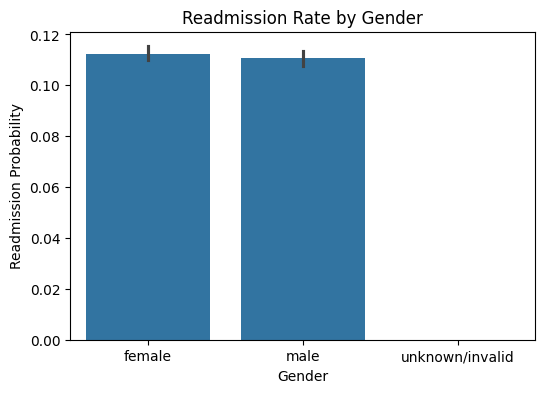

In [15]:
plt.figure(figsize=(6,4))
sns.barplot(
    x='gender',
    y='readmitted',
    data=df
)
plt.title("Readmission Rate by Gender")
plt.ylabel("Readmission Probability")
plt.xlabel("Gender")
plt.show()

## Readmission Rate By Age Group

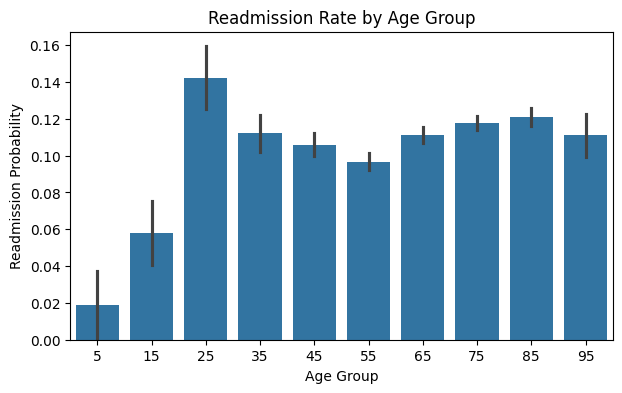

In [16]:
plt.figure(figsize=(7,4))
sns.barplot(
    x='age',
    y='readmitted',
    data=df
)
plt.title("Readmission Rate by Age Group")
plt.ylabel("Readmission Probability")
plt.xlabel("Age Group")
plt.show()


## Readmission Rate By Number of Emergency Visits

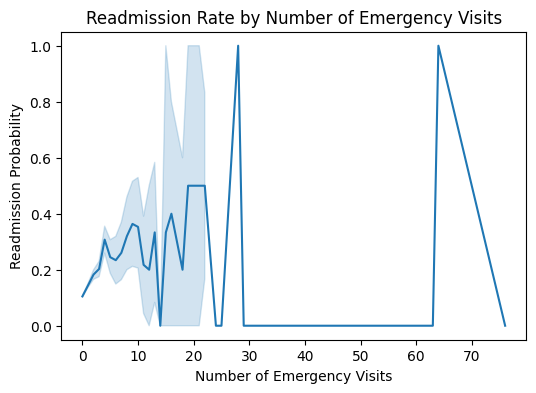

In [17]:
plt.figure(figsize=(6,4))
sns.lineplot(
    x='number_emergency',
    y='readmitted',
    data=df
)
plt.title("Readmission Rate by Number of Emergency Visits")
plt.ylabel("Readmission Probability")
plt.xlabel("Number of Emergency Visits")
plt.show()


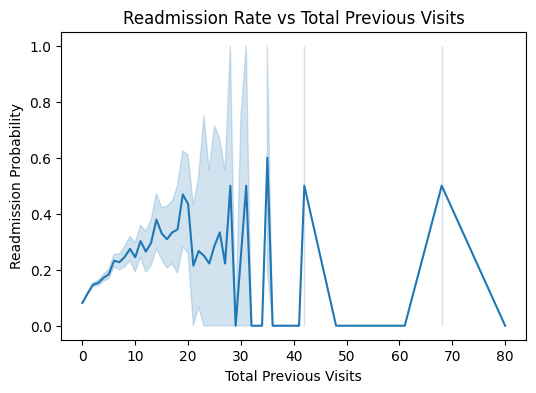

In [18]:
plt.figure(figsize=(6,4))
sns.lineplot(
    x='total_previous_visits',
    y='readmitted',
    data=df
)
plt.title("Readmission Rate vs Total Previous Visits")
plt.ylabel("Readmission Probability")
plt.xlabel("Total Previous Visits")
plt.show()


## Distribution of Time in Hospital

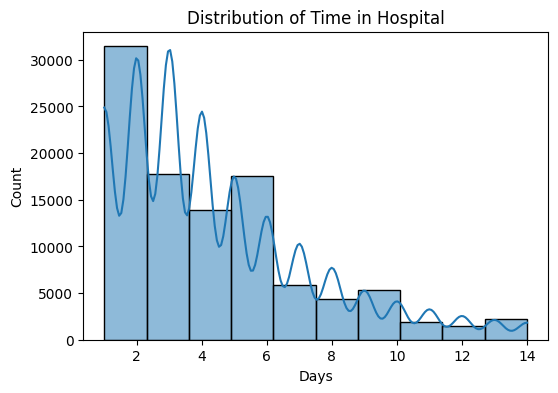

In [19]:
plt.figure(figsize=(6,4))
sns.histplot(df['time_in_hospital'], bins=10, kde=True)
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days")
plt.ylabel("Count")
plt.show()


## Correlation Heatmap

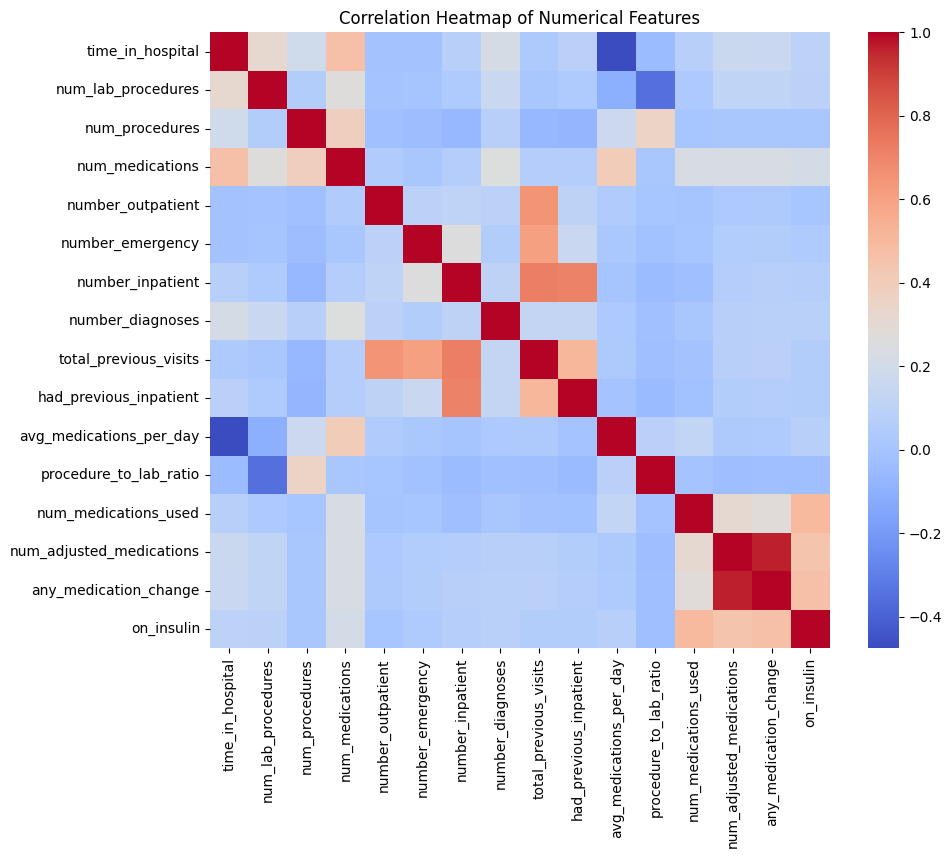

In [21]:
numerical = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses',
    'total_previous_visits',
    'had_previous_inpatient',
    'avg_medications_per_day',
    'procedure_to_lab_ratio',
    'num_medications_used',
    'num_adjusted_medications',
    'any_medication_change',
    'on_insulin'
]

plt.figure(figsize=(10,8))
sns.heatmap(df[numerical].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


# Setting up the validation framework
#### Perform the train/validation/test split with Scikit-Learn

In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [ ]:
len(df_full_train)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [ ]:
y_train = df_train.readmitted.values
y_val = df_val.readmitted.values
y_test = df_test.readmitted.values

del df_train['readmitted']
del df_val['readmitted']
del df_test['readmitted']

In [ ]:
df_full_train.readmitted.value_counts(normalize=True)

# Save splits and target variable

In [ ]:
!pip install pyarrow

In [ ]:
df_full_train.to_parquet("../data/interim/df_full_train.parquet", index=False)
df_train.to_parquet("../data/interim/df_train.parquet", index=False)
df_val.to_parquet("../data/interim/df_val.parquet", index=False)
df_test.to_parquet("../data/interim/df_test.parquet", index=False)

np.save("../data/interim/y_train.npy", y_train)
np.save("../data/interim/y_val.npy", y_val)
np.save("../data/interim/y_test.npy", y_test)
